In [1]:
from utils import Dataloader
import torch
from utils import set_seed
from models import ViTEndToEnd

device = 'cuda:5' if torch.cuda.is_available() else 'cpu'
Vit = ViTEndToEnd(num_classes=4, pretrained=True).to(device)

In [2]:
set_seed(42)
dataloader = Dataloader(
    data_dir='/home/clincango/resnet_vit/Images',
    batch_size=16
)

dataloader.setup()
test_loader  = dataloader.test_dataloader()

In [3]:
# Sanity Check
subset = test_loader.dataset   
print("Cantidad imagenes en Test:", len(subset))
print("Ruta:", subset.samples[0])   # [0] primera imagen

Cantidad imagenes en Test: 59
Ruta: ('/home/clincango/resnet_vit/Images/Test_gray/C. Foxi/f (11).png', 0)


In [4]:
import torch
import torch.nn as nn
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, MulticlassRecall,
    MulticlassF1Score, MulticlassMatthewsCorrCoef,
    MulticlassAUROC, MulticlassAveragePrecision
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---- preparar modelo y criterio ----

weights = torch.tensor([1.147, 0.723, 1.147, 1.147], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

Vit.load_state_dict(torch.load("best_vit.pt", map_location=device))
Vit.to(device).eval()

# ---- métricas ----

num_classes = 4

acc  = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
prec = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
rec  = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
f1m  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
f1w  = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
mcc  = MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
roc  = MulticlassAUROC(num_classes=num_classes, average='macro').to(device)
prc  = MulticlassAveragePrecision(num_classes=num_classes, average='macro').to(device)


running_loss, n_batches = 0.0, 0
all_preds, all_labels = [], []

with torch.inference_mode():
    for imgs, labels in test_loader:
        imgs   = imgs.to(device)
        labels = labels.to(device, dtype=torch.long)

        logits = Vit(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item(); n_batches += 1

        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        # torchmetrics
        acc.update(preds, labels);  prec.update(preds, labels);  rec.update(preds, labels)
        f1m.update(preds, labels);  f1w.update(preds, labels);   mcc.update(preds, labels)
        roc.update(probs, labels);  prc.update(probs, labels)

        # para CM
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_loss = running_loss / max(1, n_batches)
te_acc  = acc.compute().item()  * 100
te_prec = prec.compute().item() * 100
te_rec  = rec.compute().item()  * 100
te_f1m  = f1m.compute().item()  * 100
te_f1w  = f1w.compute().item()  * 100
te_mcc  = mcc.compute().item()
te_roc  = roc.compute().item()  * 100
te_prc  = prc.compute().item()  * 100

print(f"Test Loss={test_loss:.4f} | Acc={te_acc:.2f}% | PrecM={te_prec:.2f}% | "
      f"RecM={te_rec:.2f}% | F1M={te_f1m:.2f}% | F1W={te_f1w:.2f}% | "
      f"MCC={te_mcc:.4f} | AUROC_M={te_roc:.2f}% | AUPRC_M={te_prc:.2f}%")

Test Loss=0.0358 | Acc=100.00% | PrecM=100.00% | RecM=100.00% | F1M=100.00% | F1W=100.00% | MCC=1.0000 | AUROC_M=100.00% | AUPRC_M=100.00%


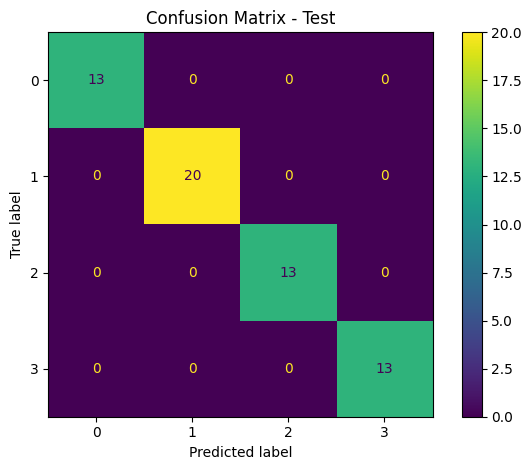

In [5]:
# ---- matriz de confusión ----
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title("Confusion Matrix - Test")
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

all_probs = []
all_labels = []

with torch.inference_mode():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = Vit(imgs)
        probs = torch.softmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)     # [N, num_classes]
all_labels = np.concatenate(all_labels)  # [N]


In [7]:
print(all_probs)       
print(all_labels)      


[[9.7926897e-01 1.5885714e-02 2.5539531e-03 2.2913017e-03]
 [9.9590391e-01 2.6199727e-03 4.6192546e-04 1.0142474e-03]
 [9.9670851e-01 1.6009430e-03 6.1713142e-04 1.0733958e-03]
 [9.8473918e-01 1.2596242e-02 8.6723303e-04 1.7973137e-03]
 [9.7354680e-01 1.7413840e-02 1.8709449e-03 7.1684169e-03]
 [9.9635881e-01 1.9942480e-03 3.4524468e-04 1.3016108e-03]
 [9.0947342e-01 8.1642933e-02 4.6884436e-03 4.1952035e-03]
 [8.7280077e-01 1.1817421e-01 1.6149586e-03 7.4099917e-03]
 [9.8774880e-01 8.2109179e-03 1.2592229e-03 2.7810934e-03]
 [9.9631459e-01 1.8308467e-03 5.0228514e-04 1.3522579e-03]
 [7.9932314e-01 1.8196797e-01 9.5482385e-03 9.1606798e-03]
 [9.9573070e-01 2.7060041e-03 4.1466209e-04 1.1486514e-03]
 [9.9511993e-01 3.2847787e-03 5.0904788e-04 1.0862579e-03]
 [5.8705779e-03 9.7989494e-01 1.2343824e-02 1.8907043e-03]
 [5.0028889e-03 9.9077374e-01 1.6058296e-03 2.6175878e-03]
 [1.3146855e-01 8.4013778e-01 5.8504366e-03 2.2543143e-02]
 [8.3249556e-03 9.7940296e-01 1.0515785e-02 1.7563780e-0

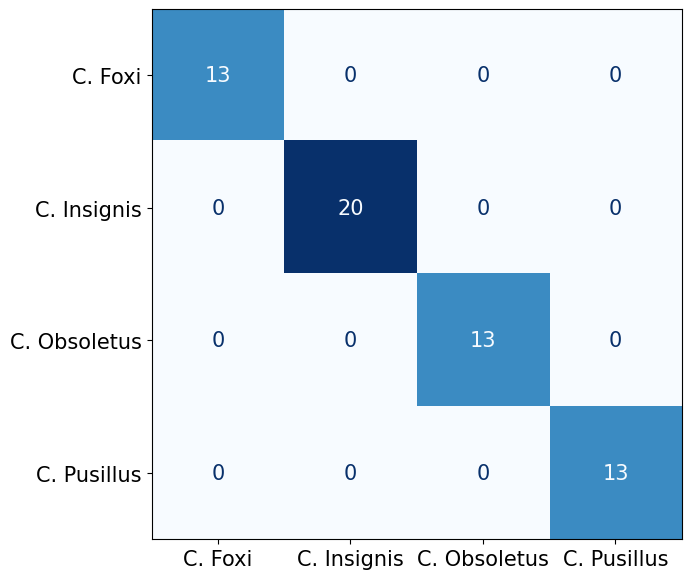

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- Datos ---
labels = ["C. Foxi", "C. Insignis", "C. Obsoletus", "C. Pusillus"]
cm = confusion_matrix(all_labels, all_preds, labels=range(len(labels)))

# --- Estética académica ---
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Verdana"],
    "axes.edgecolor": "#000000",
    "axes.linewidth": 0.8,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

fig, ax = plt.subplots(figsize=(7, 7))

# --- Matriz ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    cmap="Blues",
    ax=ax,
    colorbar=False,
    values_format="d"
)

disp.ax_.set_xlabel("")
disp.ax_.set_ylabel("")

# --- Ajustes visuales ---
#disp.ax_.set_xlabel("Etiqueta Predicha", fontsize=14)
#disp.ax_.set_ylabel("Etiqueta Verdadera", fontsize=14)
#disp.ax_.set_title("Matriz de Confusión — MLP", fontsize=16, pad=15)

# Aumentar tamaño de los números
for text in disp.ax_.texts:
    text.set_fontsize(15)

plt.tight_layout()
plt.savefig("confusion_matrix_mlp.png", dpi=600, bbox_inches="tight")
plt.show()
